In [1]:
# default_exp data.ontsloader_fast

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
from nixtla.data.ontsdataset import TimeSeriesDataset
from collections import defaultdict

In [4]:
# export
class TimeSeriesLoader(object):
    def __init__(self,
                 ts_dataset:TimeSeriesDataset,
                 model:str,
                 offset:int,
                 window_sampling_limit: int,
                 input_size: int,
                 output_size: int,
                 idx_to_sample_freq: int,
                 batch_size: int,
                 is_train_loader: bool,
                 shuffle: bool):
        """
        """
        self.model = model
        self.window_sampling_limit = window_sampling_limit
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.idx_to_sample_freq = idx_to_sample_freq
        self.offset = offset
        self.ts_dataset = ts_dataset
        self.t_cols = self.ts_dataset.t_cols
        self.X_cols = self.ts_dataset.X_cols
        self.is_train_loader = is_train_loader # Boolean variable for train and validation mask
        self.shuffle = shuffle # Boolean to shuffle data, useful for validation

        # Create rolling window matrix in advanced for faster access to data and broadcasted s_matrix
        self._create_train_data()

    def _update_sampling_windows_idxs(self):
        # Only sample during training windows with at least one active output mask and input mask
        outsample_condition = t.sum(self.ts_windows[:, self.t_cols.index('outsample_mask'), -self.output_size:], axis=1)
        insample_condition = t.sum(self.ts_windows[:, self.t_cols.index('insample_mask'), :self.input_size], axis=1)
        sampling_idx = t.nonzero(outsample_condition * insample_condition > 0) #element-wise product
        sampling_idx = list(sampling_idx.flatten().numpy())
        return sampling_idx

    def _create_windows_tensor(self):
        """
        Comment here
        TODO: Cuando creemos el otro dataloader, si es compatible lo hacemos funcion transform en utils
        """
        # Memory efficiency is gained from keeping across dataloaders common ts_tensor in dataset
        # Filter function is used to define train tensor and validation tensor with the offset
        # Default ts_idxs=ts_idxs sends all the data
        tensor, right_padding, train_mask, loss_weights = self.ts_dataset.get_filtered_ts_tensor(offset=self.offset, output_size=self.output_size,
                                                                                                 window_sampling_limit=self.window_sampling_limit)
        tensor = t.Tensor(tensor)

        # Outsample mask checks existance of values in ts, train_mask mask is used to filter out validation
        # is_train_loader inverts the train_mask in case the dataloader is in validation mode
        mask = train_mask if self.is_train_loader else (1 - train_mask)
        tensor[:, self.t_cols.index('outsample_mask'), :] = tensor[:, self.t_cols.index('outsample_mask'), :] * mask
        # Weighted loss through outsample_mask
        tensor[:, self.t_cols.index('outsample_mask'), :] = tensor[:, self.t_cols.index('outsample_mask'), :] * loss_weights

        padder = t.nn.ConstantPad1d(padding=(self.input_size, right_padding), value=0)
        tensor = padder(tensor)

        # Last output_size outsample_mask and y to 0
        tensor[:, self.t_cols.index('y'), -self.output_size:] = 0 # overkill to ensure no validation leakage
        tensor[:, self.t_cols.index('outsample_mask'), -self.output_size:] = 0

        # Creating rolling windows and 'flattens' them
        windows = tensor.unfold(dimension=-1, size=self.input_size + self.output_size, step=self.idx_to_sample_freq)
        # n_serie, n_channel, n_time, window_size -> n_serie, n_time, n_channel, window_size
        #print(f'n_serie, n_channel, n_time, window_size = {windows.shape}')
        windows = windows.permute(0,2,1,3)
        #print(f'n_serie, n_time, n_channel, window_size = {windows.shape}')
        windows = windows.reshape(-1, self.ts_dataset.n_channels, self.input_size + self.output_size)

        # Broadcast s_matrix: This works because unfold in windows_tensor, orders: time, serie
        s_matrix = self.ts_dataset.s_matrix.repeat(repeats=int(len(windows)/self.ts_dataset.n_series), axis=0)

        return windows, s_matrix

    def __len__(self):
        return len(self.len_series)

    def __iter__(self):
        if self.shuffle:
            sample_idxs = np.random.choice(a=self.windows_sampling_idx,
                                            size=len(self.windows_sampling_idx), replace=False)
        else:
            sample_idxs = self.windows_sampling_idx
        
        assert len(sample_idxs)>0, 'Check the data as sample_idxs are empty'

        n_batches = int(np.ceil(len(sample_idxs) / self.batch_size)) # Must be multiple of batch_size for paralel gpu
        
        for idx in range(n_batches):
            ws_idxs = sample_idxs[(idx * self.batch_size) : (idx + 1) * self.batch_size]
            batch = self.__get_item__(index=ws_idxs)
            yield batch

    def __get_item__(self, index):
        if self.model == 'nbeats':
            return self._nbeats_batch(index)
        elif self.model == 'esrnn':
            assert 1<0, 'hacer esrnn'
        else:
            assert 1<0, 'error'

    def _nbeats_batch(self, index):
        windows = self.ts_windows[index]
        s_matrix = self.s_matrix[index]

        # insample y as ejecutado
        insample_y = windows[:, self.t_cols.index('ejecutado'), :self.input_size]
        # Remove both y and ejecutado
        insample_x = windows[:, (self.t_cols.index('ejecutado') + 1):self.t_cols.index('insample_mask'), :self.input_size]
        insample_mask = windows[:, self.t_cols.index('insample_mask'), :self.input_size]

        # y as outsample y
        outsample_y = windows[:, self.t_cols.index('y'), self.input_size:]
        # Remove both y and ejecutado
        outsample_x = windows[:, (self.t_cols.index('ejecutado') + 1):self.t_cols.index('insample_mask'), self.input_size:]
        outsample_mask = windows[:, self.t_cols.index('outsample_mask'), self.input_size:]

        batch = {'s_matrix': s_matrix,
                 'insample_y': insample_y, 'insample_x':insample_x, 'insample_mask':insample_mask,
                 'outsample_y': outsample_y, 'outsample_x':outsample_x, 'outsample_mask':outsample_mask}
        return batch

    def _create_train_data(self):
        """
        """
        #print('Creating windows matrix ...')
        # Create rolling window matrix for fast information retrieval
        self.ts_windows, self.s_matrix = self._create_windows_tensor()
        self.n_windows = len(self.ts_windows)
        self.windows_sampling_idx  = self._update_sampling_windows_idxs()

    def update_offset(self, offset):
        if offset == self.offset:
            return # Avoid extra computation
        self.offset = offset
        self._create_train_data()

    def get_meta_data_col(self, col):
        return self.ts_dataset.get_meta_data_col(col)

    def get_n_variables(self):
        return self.ts_dataset.n_x, self.ts_dataset.n_s

    def get_n_series(self):
        return self.ts_dataset.n_series

    def get_max_len(self):
        return self.ts_dataset.max_len

    def get_n_channels(self):
        return self.ts_dataset.n_channels

    def get_X_cols(self):
        return self.ts_dataset.X_cols

    def get_frequency(self):
        return self.ts_dataset.frequency

In [5]:
import matplotlib.pyplot as plt
from nixtla.data.datasets.on import load_on_data

Y_insample_df, X_insample_df, Y_outsample_df, X_outsample_df, f_cols = load_on_data(root_dir='../data/on',
                                                                                    test_date='2020-11-01')

In [9]:
train_outsample_mask = np.ones(len(Y_insample_df))
train_outsample_mask[-60 * 24 * 4:] = 0 # 60 days x 24 hours x 4 fifteenminutales

loss_weights = 2 * np.ones(len(Y_insample_df))

print("sum(train_outsample_mask)", sum(train_outsample_mask))

on_dataset = TimeSeriesDataset(Y_df=Y_insample_df,
                               S_df=None, X_df=X_insample_df,
                               f_cols=f_cols,
                               ts_train_mask=train_outsample_mask,
                               loss_weights=loss_weights)

sum(train_outsample_mask) 101856.0
Processing dataframes ...
Creating ts tensor ...


In [10]:
ts_loader = TimeSeriesLoader(ts_dataset=on_dataset,
                             model='nbeats',
                             offset=0,
                             window_sampling_limit=365*4*24, 
                             input_size=2*16,
                             output_size=16,
                             idx_to_sample_freq=1,
                             batch_size= 256,
                             is_train_loader=True,
                             shuffle=True)

In [11]:
dataloader = iter(ts_loader)
batch = next(dataloader)
insample_y = batch['insample_y']
insample_x = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_y = batch['outsample_y']
outsample_x = batch['outsample_x']
outsample_mask = batch['outsample_mask']

print("on_dataset.t_cols", on_dataset.t_cols)
print("ts_loader.input_size", ts_loader.input_size)
print("ts_loader.output_size", ts_loader.output_size)
print("insample_y.shape", insample_y.shape)
print("insample_x.shape", insample_x.shape)
print("outsample_y.shape", outsample_y.shape)
print("outsample_x.shape", outsample_x.shape)

on_dataset.t_cols ['y', 'ejecutado', 'DECIMAL_HOUR', 'DAY_OF_YEAR', 'DAY_OF_WEEK', 'IS_WEEKDAY', 'IS_HOLIDAY', 'L_1', 'L_2', 'L_3', 'L_4', 'L_5', 'L_6', 'L_7', 'PE_1', 'PD_1', 'PS_1', 'PE_7', 'PD_7', 'PS_7', 'PD_0', 'PS_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7', 'AVG_1', 'AVG_2', 'AVG_3', 'AVG_4', 'AVG_5', 'AVG_6', 'AVG_7', 'MOV_7', 'MOV_14', 'DELTA_1', 'DELTA_7', 'PEAK_TIME_1', 'PEAK_TIME_2', 'PEAK_TIME_3', 'PEAK_TIME_4', 'PEAK_TIME_5', 'PEAK_TIME_6', 'PEAK_TIME_7', 'PE_PP1', 'PE_PP2', 'PE_PP3', 'PE_PP4', 'PE_PP5', 'PE_PP6', 'PE_PP7', 'PE_PP8', 'PE_PP9', 'PE_PP10', 'PE_PP11', 'PE_PP12', 'PE_PP13', 'PE_PP14', 'PE_PP15', 'PE_PP16', 'PE_PP17', 'PE_PP18', 'PE_PP19', 'PE_PP20', 'PE_PP21', 'PE_PP22', 'PE_PP23', 'PE_PP24', 'PE_PP25', 'PE_PP26', 'PE_PP27', 'PE_PP28', 'PE_PP29', 'PE_PP30', 'PE_PP31', 'PE_PP32', 'PE_PP33', 'PE_PP34', 'PE_PP35', 'PE_PP36', 'PE_PP37', 'PE_PP38', 'PE_PP39', 'PE_PP40', 'PE_PP41', 'PE_PP42', 'PE_PP43', 'PE_PP44', 'PE_PP45', 'PE_PP46', 'PE_PP47', 'PE_PP48',

In [14]:
outsample_mask

tensor([[2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        ...,
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.]])

In [12]:
ts_loader = TimeSeriesLoader(ts_dataset=on_dataset,
                             model='nbeats',
                             offset=0,
                             window_sampling_limit=365*4*24, 
                             input_size=3*24,
                             output_size=24,
                             idx_to_sample_freq=1,
                             batch_size= 2048,
                             is_train_loader=True,
                             shuffle=False)

insample_x.shape torch.Size([2048, 328, 72])
insample_x.shape torch.Size([2048, 328, 72])
insample_x.shape torch.Size([2048, 328, 72])
check_x.shape (6144, 328, 72)
Checking order for unshuffled validation


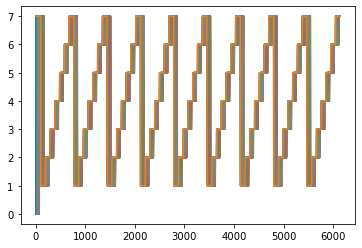

In [13]:
check_list = []
for i, batch in enumerate(ts_loader):
    insample_y = batch['insample_y']
    insample_x = batch['insample_x']
    insample_mask = batch['insample_mask']
    outsample_y = batch['outsample_y']
    outsample_x = batch['outsample_x']
    outsample_mask = batch['outsample_mask']

    #print("on_dataset.t_cols", on_dataset.t_cols)
    #print("ts_loader.input_size", ts_loader.input_size)
    #print("ts_loader.output_size", ts_loader.output_size)
    #print("insample_y.shape", insample_y.shape)
    print("insample_x.shape", insample_x.shape)
    #print("outsample_y.shape", outsample_y.shape)
    #print("outsample_x.shape", outsample_x.shape)

    check_list += [insample_x]

    if i>1: break

check_x = np.vstack(check_list)
print("check_x.shape", check_x.shape)
print("Checking order for unshuffled validation")
plt.plot(check_x[:,2,:])
plt.show()